# EXC responses differ across layer

### Setup

In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import spikeinterface as si
import numpy as np
from collections import Counter
import pandas as pd
import random
import warnings
import pickle
from sklearn.preprocessing import LabelEncoder
import yaml

# dimensionality reduction
from sklearn.decomposition import PCA 
from cebra import CEBRA
import cebra
import torch 

warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

# GET STIMULUS CONF
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023"
os.chdir(PROJ_PATH)
from src.nodes.utils import get_config

data_conf, _ = get_config("silico_neuropixels", "stimulus").values()
GT_SORTING_PATH = data_conf["sorting"]["simulation"]["ground_truth"]["output"]
RECORDING_PATH = data_conf["probe_wiring"]["output"]


# GET STIM-REP CONF
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/stim-rep"
os.chdir(PROJ_PATH)

with open(
    f"conf/silico_npx/stimulus/dataset.yml",
    "r",
    encoding="utf-8",
) as data_conf:
    data_conf = yaml.safe_load(data_conf)

# MODELS
CEBRA_MODEL_MTLYR_TRIAL_PATH = data_conf['models']['cebra']['models']['multilayer_trialwise']
CEBRA_MODEL_MTLYR_UNIT_PATH = data_conf['models']['cebra']['models']['multilayer_unitwise']

# EMBEDDINGS
CEBRA_EMBED_MTLYR_TRIAL_PATH = data_conf['models']['cebra']['embed']['multilayer_trialwise']
CEBRA_EMBED_MTLYR_UNIT_PATH = data_conf['models']['cebra']['embed']['multilayer_unitwise']

# TASK DESIGN PARAMETERS
N_SIMS = 36 # number of simulation files

# FIGURE SETTINGS
plt.rcParams['figure.figsize'] = (2,1)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6
plt.rcParams['lines.linewidth'] = 0.5
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.major.width'] = 0.3
plt.rcParams['xtick.minor.size'] = 0.1
plt.rcParams['xtick.major.size'] = 1.5
plt.rcParams['ytick.major.size'] = 1.5
plt.rcParams['ytick.major.width'] = 0.3
legend_cfg = {"frameon": False, "handletextpad": 0.1}
savefig_cfg = {"transparent":True, "dpi":300} 

2024-05-12 16:11:16,608 - root - utils.py - get_config - INFO - Reading experiment config.
2024-05-12 16:11:16,633 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Custom functions

In [2]:
def plot_manifold_dims_1_2(manifold: dict, params, ax, axis_lim):

    # downsample manifold for speed
    # and memory efficiency
    DOWNSAMPLE = 10

    # color the stimulus orientations
    cmap = params["orientations"][::DOWNSAMPLE]

    # plot neural manifold
    scat = ax.scatter(
        manifold["manifold"][::DOWNSAMPLE, 0],
        manifold["manifold"][::DOWNSAMPLE, 1],
        c=cmap,
        edgecolors="w",
        linewidths=0.2,
        rasterized=True,  # memory efficiency
    )

    # add legend
    ax.set_xlim(axis_lim)
    ax.set_ylim(axis_lim)
    ax.set_xticklabels([-0.5, 0, 0.5, 1])
    ax.set_yticklabels([-0.5, 0, 0.5, 1])
    ax.set_xticks([-0.5, 0, 0.5, 1])
    ax.set_yticks([-0.5, 0, 0.5, 1])
    # cbar = plt.colorbar(scat, ticks=[0, 90, 180, 270, 359], fraction=0.026, pad=0.04)
    # cbar.ax.set_ylabel("Stimulus orientations (deg)", rotation=270, labelpad=7)
    # cbar.ax.set_yticklabels([0, 90, 180, 270, 359])

    # legend
    ax.set_xlabel("Neural latent 1")
    ax.set_ylabel("Neural latent 2")
    ax.spines[["top", "right"]].set_visible(False)
    ax.set_box_aspect((1))
    return ax


def get_stimulus_intervals_ms(epoch_labels, epoch_ms):

    # find stimulus epoch starts and ends
    epoch_end_ms = np.cumsum(epoch_ms)
    epoch_start_ms = np.hstack([0, epoch_end_ms])[:-1]
    df = pd.DataFrame(data=epoch_end_ms)
    df.columns = ["end"]
    df.insert(0, "start", epoch_start_ms)
    df.index = epoch_labels

    # get stimulus intervals
    return [tuple(df.iloc[ix]) for ix in range(len(df)) if df.index[ix] == "stimulus"]


def get_stimulus_labels():
    start = np.arange(0, 360, 10)
    end = np.arange(10, 370, 10)

    stimulus_labels = []
    for ix in range(36):
        stimulus_labels.append(np.repeat(np.arange(start[ix], end[ix], 1), 50))
    return np.array(stimulus_labels).flatten()


def get_task_parameters(
    start_delay=500,
    n_orientations=10,
    n_repeats=50,
    stimulus_duration=200,
    n_simulations=36,
):
    # get epoch timings
    epoch_ms = n_simulations * (
        [start_delay] + n_orientations * n_repeats * [stimulus_duration]
    )
    # get epoch labels
    epoch_labels = n_simulations * (
        ["delay"] + n_orientations * n_repeats * ["stimulus"]
    )

    return {"epoch_labels": epoch_labels, "epoch_ms": epoch_ms}


def get_evoked_responses(spike_trains_ms: np.array, stim_intervals_ms: np.array):
    """_summary_

    Args:
        spike_trains_ms (np.array): _description_
        stim_intervals_ms (np.array): array of tuples (start, end)

    Returns:
        _type_: _description_
    """
    # Use numpy's digitize function to find the bin indices for each value
    bins = [interval[1] for interval in stim_intervals_ms]

    # Return the indices of the bins to which each value in spike_trains_ms belongs.
    bin_indices = np.digitize(spike_trains_ms, bins=bins)

    # Use Counter to count occurrences of bin indices
    interval_counter = Counter(bin_indices)

    # find active stimulus epochs
    active_bin_spike_count = [items[1] for items in list(interval_counter.items())]
    active_bin_ix = [items[0] for items in list(interval_counter.items())]

    # cast unit responses by stimulus epoch in an array
    unit_responses = np.zeros(len(bins))
    unit_responses[active_bin_ix] = active_bin_spike_count
    return unit_responses


def convert_spike_trains_to_ms(spike_trains: np.array, sfreq: int):
    """_summary_

    Args:
        spike_trains (np.array): _description_
        sfreq (int): _description_

    Returns:
        _type_: _description_
    """
    sample_ms = 1 / (sfreq / 1000)
    spike_trains_ms = spike_trains * sample_ms
    return spike_trains_ms


def compute_response_by_stim_matrix(unit_ids, SortingTrueKS3, stimulus_intervals_ms):
    """_summary_

    Args:
        SortingTrueKS3 (_type_): _description_
        stimulus_intervals_ms (_type_): _description_

    Returns:
        _type_: _description_
    """
    SFREQ = SortingTrueKS3.get_sampling_frequency()

    # takes 18 secs
    responses = []
    for unit_id in unit_ids:
        spike_trains = SortingTrueKS3.get_unit_spike_train(unit_id)
        spike_trains_ms = convert_spike_trains_to_ms(spike_trains, SFREQ)
        responses.append(get_evoked_responses(spike_trains_ms, stimulus_intervals_ms))
    return np.array(responses)


def plot_manifold_from_pca(responses: np.ndarray, params: dict, ax, axis_lim):
    """PLot manifold

    Args:
      responses (np.ndarray): neurons x stimulus

    Returns:
        (dict)
    """
    # fit pca to neural responses
    pca = PCA(n_components=params["dims"])  # parametrize pca
    manifold = pca.fit_transform(responses.T)  # apply pca
    manifold = manifold / np.max(np.abs(manifold))  # normalise the values

    # setup plot parameters
    DOWNSAMPLE = 10

    # setup plot
    plt.set_cmap("hsv")  # circular cmap

    # 3D projection
    ax.view_init(20, 45, 0)  # elevation, azimuth, roll

    # color the stimulus orientations
    cmap = params["orientations"][::DOWNSAMPLE]

    # plot neural manifold
    scat = ax.scatter(
        manifold[::DOWNSAMPLE, 0],
        manifold[::DOWNSAMPLE, 1],
        manifold[::DOWNSAMPLE, 2],
        c=cmap,
        edgecolors="w",
        linewidths=0.2,
        s=2,
        rasterized=True,  # memory efficiency
    )

    # add legend
    ax.set_xlim(axis_lim)
    ax.set_ylim(axis_lim)
    ax.set_zlim(axis_lim)
    cbar = plt.colorbar(scat, ticks=[0, 90, 180, 270, 359], fraction=0.026, pad=0.04)
    cbar.ax.set_ylabel("Stimulus orientations (deg)", rotation=270, labelpad=7)
    cbar.ax.set_yticklabels([0, 90, 180, 270, 359])
    ax.set_xlabel("Neural latent 1")
    ax.set_ylabel("Neural latent 2")
    ax.set_zlabel("Neural latent 3")
    ax.set_xticks([-0.5, 0, 0.5, 1])
    ax.set_yticks([-0.5, 0, 0.5, 1])
    ax.set_zticks([-0.5, 0, 0.5, 1])
    ax.set_xticklabels(
        [-0.5, 0, 0.5, 1], verticalalignment="baseline", horizontalalignment="right"
    )
    ax.set_yticklabels(
        [-0.5, 0, 0.5, 1], verticalalignment="baseline", horizontalalignment="right"
    )
    ax.set_zticklabels(
        [-0.5, 0, 0.5, 1], verticalalignment="baseline", horizontalalignment="right"
    )
    ax.tick_params(axis="x", which="major", pad=-3)
    ax.tick_params(axis="y", which="major", pad=-3)
    ax.tick_params(axis="z", which="major", pad=-3)
    ax.set_xlabel("Neural latent 1", labelpad=-10)
    ax.set_ylabel("Neural latent 2", labelpad=-10)
    ax.set_zlabel("Neural latent 3", labelpad=-5)
    ax.spines[["top", "right"]].set_visible(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.set_box_aspect((1, 1, 1))
    print("manifold axis max:", max(manifold.max(axis=1)))
    print("manifold axis min:", min(manifold.min(axis=1)))
    return {"manifold": manifold, "pca_model": pca, "ax": ax}

### Load dataset

In [3]:
# sorting
SortingTrue = si.load_extractor(GT_SORTING_PATH)

# unit layers
unit_layers = SortingTrue.get_property("layer")
print("# of unit layers:", len(np.unique(unit_layers)))
print("unique unit layers:", np.unique(unit_layers))

# recording
Recording = si.load_extractor(RECORDING_PATH)
print("# of units:", len(SortingTrue.unit_ids))

# get task epoch infos
task = get_task_parameters(
    start_delay=500,
    n_orientations=10,
    n_repeats=50,
    stimulus_duration=200,
    n_simulations=36,
)

# STIMULUS  ***********

# get stimulus labels
stimulus_labels = get_stimulus_labels()
print("# of stimulus trials:", len(stimulus_labels))
print("# of stimulus orientations:", len(np.unique(stimulus_labels)))

# get stimulus orientation labels
stimulus_intervals_ms = get_stimulus_intervals_ms(
    task["epoch_labels"], task["epoch_ms"]
)

print("orientations:", stimulus_intervals_ms)

# NEURAL RESPONSE ***********

# compute unit x stimulus response matrix
responses = compute_response_by_stim_matrix(
    SortingTrue.unit_ids, SortingTrue, stimulus_intervals_ms
)

# UNIT LABELS ***********

syn = SortingTrue.get_property("synapse_class")
enc = LabelEncoder()
unit_labels = [
    np.array([enc.fit_transform(syn[(unit_layers == "2") | (unit_layers == "3")])])
    .astype(np.float32)
    .T,
    np.array([enc.fit_transform(syn[unit_layers == "4"])]).astype(np.float32).T,
    np.array([enc.fit_transform(syn[unit_layers == "5"])]).astype(np.float32).T,
    np.array([enc.fit_transform(syn[unit_layers == "6"])]).astype(np.float32).T,
]

# of unit layers: 6
unique unit layers: ['1' '2' '3' '4' '5' '6']
# of units: 1836
# of stimulus trials: 18000
# of stimulus orientations: 360
orientations: [(500, 700), (700, 900), (900, 1100), (1100, 1300), (1300, 1500), (1500, 1700), (1700, 1900), (1900, 2100), (2100, 2300), (2300, 2500), (2500, 2700), (2700, 2900), (2900, 3100), (3100, 3300), (3300, 3500), (3500, 3700), (3700, 3900), (3900, 4100), (4100, 4300), (4300, 4500), (4500, 4700), (4700, 4900), (4900, 5100), (5100, 5300), (5300, 5500), (5500, 5700), (5700, 5900), (5900, 6100), (6100, 6300), (6300, 6500), (6500, 6700), (6700, 6900), (6900, 7100), (7100, 7300), (7300, 7500), (7500, 7700), (7700, 7900), (7900, 8100), (8100, 8300), (8300, 8500), (8500, 8700), (8700, 8900), (8900, 9100), (9100, 9300), (9300, 9500), (9500, 9700), (9700, 9900), (9900, 10100), (10100, 10300), (10300, 10500), (10500, 10700), (10700, 10900), (10900, 11100), (11100, 11300), (11300, 11500), (11500, 11700), (11700, 11900), (11900, 12100), (12100, 12300)

### (40m)Embeddings (multi-layers)

In [9]:
# parametrize
MAX_ITER = 8000
LOAD = True

# get neural responses by layer
names = ["L2/3", "L4", "L5", "L6"]
datas = [
    responses[(unit_layers == "2") | (unit_layers == "3"), :],
    responses[unit_layers == "4", :],
    responses[unit_layers == "5", :],
    responses[unit_layers == "6", :],
]

# train and save models
if not LOAD:
    torch.manual_seed(0)

    # cebra-behavior model
    cebra_multilayer_unitwise_model = CEBRA(
        model_architecture="offset5-model",  # CEBRA model with a 5 sample receptive field and output normalization.
        batch_size=1200,  # 1200,  # 512, # must be 512
        learning_rate=1e-4,
        temperature=1,
        output_dimension=3,
        max_iterations=MAX_ITER,  # 8000,
        distance="cosine",
        conditional="time_delta",
        device="cuda_if_available",
        verbose=True,
        time_offsets=10,
    )

    # train
    cebra_multilayer_unitwise_model.fit(datas, unit_labels)
    cebra_multilayer_unitwise_model.save(CEBRA_MODEL_MTLYR_UNIT_PATH)

    # get each layer's embedding
    multilayer_unitwise_embeddings = dict()
    for i, (name, X) in enumerate(zip(names, datas)):
        multilayer_unitwise_embeddings[name] = (
            cebra_multilayer_unitwise_model.transform(X, session_id=i)
        )

else:
    cebra_multilayer_unitwise_model = cebra.CEBRA.load(CEBRA_MODEL_MTLYR_UNIT_PATH)

    # get each layer's embedding
    multilayer_unitwise_embeddings = dict()
    for i, (name, X) in enumerate(zip(names, datas)):
        multilayer_unitwise_embeddings[name] = (
            cebra_multilayer_unitwise_model.transform(X, session_id=i)
        )

#### Plot Exc.

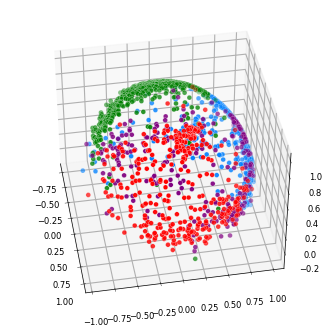

In [45]:
# plot
SIZE = 12

fig = plt.figure(figsize=(15, 4))

# plot
ax = fig.add_subplot(1, 1, 1, projection="3d")
ax.view_init(40, -10, 0)  # elevation, azimuth, rol

# ax.view_init(-20, -45, 0)  # elevation, azimuth, roll
scat = ax.scatter(
    multilayer_unitwise_embeddings["L2/3"][np.where(unit_labels[0] == 0)[0], 0],
    multilayer_unitwise_embeddings["L2/3"][np.where(unit_labels[0] == 0)[0], 1],
    multilayer_unitwise_embeddings["L2/3"][np.where(unit_labels[0] == 0)[0], 2],
    edgecolors="w",
    color="r",
    linewidths=0.2,
    s=SIZE,
    rasterized=True,  # memory efficiency
)

# plot
scat = ax.scatter(
    multilayer_unitwise_embeddings["L4"][np.where(unit_labels[1] == 0)[0], 0],
    multilayer_unitwise_embeddings["L4"][np.where(unit_labels[1] == 0)[0], 1],
    multilayer_unitwise_embeddings["L4"][np.where(unit_labels[1] == 0)[0], 2],
    edgecolors="w",
    color="purple",
    linewidths=0.2,
    s=SIZE,
    rasterized=True,  # memory efficiency
)

# plot
scat = ax.scatter(
    multilayer_unitwise_embeddings["L5"][np.where(unit_labels[2] == 0)[0], 0],
    multilayer_unitwise_embeddings["L5"][np.where(unit_labels[2] == 0)[0], 1],
    multilayer_unitwise_embeddings["L5"][np.where(unit_labels[2] == 0)[0], 2],
    edgecolors="w",
    color=[0, 0.5, 1],
    linewidths=0.2,
    s=SIZE,
    rasterized=True,  # memory efficiency
)

# plot
scat = ax.scatter(
    multilayer_unitwise_embeddings["L6"][np.where(unit_labels[3] == 0)[0], 0],
    multilayer_unitwise_embeddings["L6"][np.where(unit_labels[3] == 0)[0], 1],
    multilayer_unitwise_embeddings["L6"][np.where(unit_labels[3] == 0)[0], 2],
    edgecolors="w",
    color="green",
    linewidths=0.2,
    s=SIZE,
    rasterized=True,
)

# save
plt.savefig(
    PROJ_PATH + "/figures/cell_type/exc_multilayer_training_all_types_v1.svg",
    **savefig_cfg
)

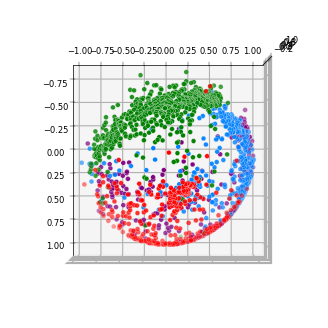

In [59]:
# plot
SIZE = 12

fig = plt.figure(figsize=(15, 4))

# plot
ax = fig.add_subplot(1, 1, 1, projection="3d")
ax.view_init(90, 90, 90)  # elevation, azimuth, rol

# ax.view_init(-20, -45, 0)  # elevation, azimuth, roll
scat = ax.scatter(
    multilayer_unitwise_embeddings["L2/3"][np.where(unit_labels[0] == 0)[0], 0],
    multilayer_unitwise_embeddings["L2/3"][np.where(unit_labels[0] == 0)[0], 1],
    multilayer_unitwise_embeddings["L2/3"][np.where(unit_labels[0] == 0)[0], 2],
    edgecolors="w",
    color="r",
    linewidths=0.2,
    s=SIZE,
    rasterized=True,  # memory efficiency
)

# plot
scat = ax.scatter(
    multilayer_unitwise_embeddings["L4"][np.where(unit_labels[1] == 0)[0], 0],
    multilayer_unitwise_embeddings["L4"][np.where(unit_labels[1] == 0)[0], 1],
    multilayer_unitwise_embeddings["L4"][np.where(unit_labels[1] == 0)[0], 2],
    edgecolors="w",
    color="purple",
    linewidths=0.2,
    s=SIZE,
    rasterized=True,  # memory efficiency
)

# plot
scat = ax.scatter(
    multilayer_unitwise_embeddings["L5"][np.where(unit_labels[2] == 0)[0], 0],
    multilayer_unitwise_embeddings["L5"][np.where(unit_labels[2] == 0)[0], 1],
    multilayer_unitwise_embeddings["L5"][np.where(unit_labels[2] == 0)[0], 2],
    edgecolors="w",
    color=[0, 0.5, 1],
    linewidths=0.2,
    s=SIZE,
    rasterized=True,  # memory efficiency
)

# plot
scat = ax.scatter(
    multilayer_unitwise_embeddings["L6"][np.where(unit_labels[3] == 0)[0], 0],
    multilayer_unitwise_embeddings["L6"][np.where(unit_labels[3] == 0)[0], 1],
    multilayer_unitwise_embeddings["L6"][np.where(unit_labels[3] == 0)[0], 2],
    edgecolors="w",
    color="green",
    linewidths=0.2,
    s=SIZE,
    rasterized=True,
)

# save
plt.savefig(
    PROJ_PATH + "/figures/cell_type/exc_multilayer_training_all_types_v2.svg",
    **savefig_cfg
)

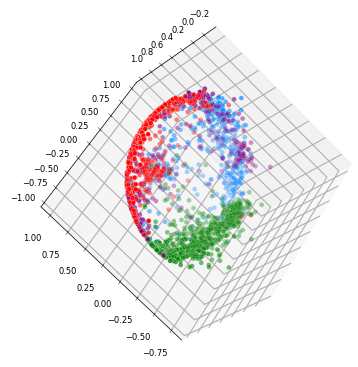

In [60]:
# plot
SIZE = 12

fig = plt.figure(figsize=(15, 4))

# plot
ax = fig.add_subplot(1, 1, 1, projection="3d")
ax.view_init(-50, -70, 120)  # elevation, azimuth, rol

# ax.view_init(-20, -45, 0)  # elevation, azimuth, roll
scat = ax.scatter(
    multilayer_unitwise_embeddings["L2/3"][np.where(unit_labels[0] == 0)[0], 0],
    multilayer_unitwise_embeddings["L2/3"][np.where(unit_labels[0] == 0)[0], 1],
    multilayer_unitwise_embeddings["L2/3"][np.where(unit_labels[0] == 0)[0], 2],
    edgecolors="w",
    color="r",
    linewidths=0.2,
    s=SIZE,
    rasterized=True,  # memory efficiency
)

# plot
scat = ax.scatter(
    multilayer_unitwise_embeddings["L4"][np.where(unit_labels[1] == 0)[0], 0],
    multilayer_unitwise_embeddings["L4"][np.where(unit_labels[1] == 0)[0], 1],
    multilayer_unitwise_embeddings["L4"][np.where(unit_labels[1] == 0)[0], 2],
    edgecolors="w",
    color="purple",
    linewidths=0.2,
    s=SIZE,
    rasterized=True,  # memory efficiency
)

# plot
scat = ax.scatter(
    multilayer_unitwise_embeddings["L5"][np.where(unit_labels[2] == 0)[0], 0],
    multilayer_unitwise_embeddings["L5"][np.where(unit_labels[2] == 0)[0], 1],
    multilayer_unitwise_embeddings["L5"][np.where(unit_labels[2] == 0)[0], 2],
    edgecolors="w",
    color=[0, 0.5, 1],
    linewidths=0.2,
    s=SIZE,
    rasterized=True,  # memory efficiency
)

# plot
scat = ax.scatter(
    multilayer_unitwise_embeddings["L6"][np.where(unit_labels[3] == 0)[0], 0],
    multilayer_unitwise_embeddings["L6"][np.where(unit_labels[3] == 0)[0], 1],
    multilayer_unitwise_embeddings["L6"][np.where(unit_labels[3] == 0)[0], 2],
    edgecolors="w",
    color="green",
    linewidths=0.2,
    s=SIZE,
    rasterized=True,
)
# save
plt.savefig(
    PROJ_PATH + "/figures/cell_type/exc_multilayer_training_all_types_v3.svg",
    **savefig_cfg
)

#### Plot INH

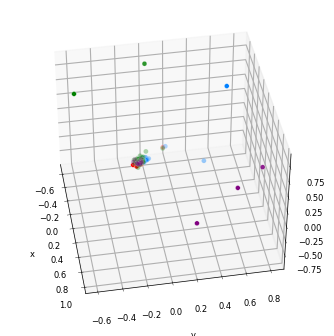

In [72]:
# plot
SIZE = 12

fig = plt.figure(figsize=(15, 4))

# plot
ax = fig.add_subplot(1, 1, 1, projection="3d")
ax.view_init(40, -10, 0)  # elevation, azimuth, rol

# ax.view_init(-20, -45, 0)  # elevation, azimuth, roll
scat = ax.scatter(
    multilayer_unitwise_embeddings["L2/3"][np.where(unit_labels[0] == 1)[0], 0],
    multilayer_unitwise_embeddings["L2/3"][np.where(unit_labels[0] == 1)[0], 1],
    multilayer_unitwise_embeddings["L2/3"][np.where(unit_labels[0] == 1)[0], 2],
    edgecolors="w",
    color="r",
    linewidths=0.2,
    s=SIZE,
    rasterized=True,  # memory efficiency
)

# plot
scat = ax.scatter(
    multilayer_unitwise_embeddings["L4"][np.where(unit_labels[1] == 1)[0], 0],
    multilayer_unitwise_embeddings["L4"][np.where(unit_labels[1] == 1)[0], 1],
    multilayer_unitwise_embeddings["L4"][np.where(unit_labels[1] == 1)[0], 2],
    edgecolors="w",
    color="purple",
    linewidths=0.2,
    s=SIZE,
    rasterized=True,  # memory efficiency
)

# plot
scat = ax.scatter(
    multilayer_unitwise_embeddings["L5"][np.where(unit_labels[2] == 1)[0], 0],
    multilayer_unitwise_embeddings["L5"][np.where(unit_labels[2] == 1)[0], 1],
    multilayer_unitwise_embeddings["L5"][np.where(unit_labels[2] == 1)[0], 2],
    edgecolors="w",
    color=[0, 0.5, 1],
    linewidths=0.2,
    s=SIZE,
    rasterized=True,  # memory efficiency
)

# plot
scat = ax.scatter(
    multilayer_unitwise_embeddings["L6"][np.where(unit_labels[3] == 1)[0], 0],
    multilayer_unitwise_embeddings["L6"][np.where(unit_labels[3] == 1)[0], 1],
    multilayer_unitwise_embeddings["L6"][np.where(unit_labels[3] == 1)[0], 2],
    edgecolors="w",
    color="green",
    linewidths=0.2,
    s=SIZE,
    rasterized=True,
)

plt.xlabel("x")
plt.ylabel("y")

# save
plt.savefig(
    PROJ_PATH + "/figures/cell_type/inh_multilayer_training_all_types_v1.svg",
    **savefig_cfg
)

### Inspect each unit

In [186]:
ix = 3

(-0.75, 0.75)

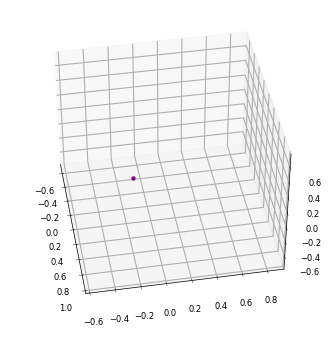

In [187]:
fig = plt.figure(figsize=(15, 4))

# plot
ax = fig.add_subplot(1, 1, 1, projection="3d")
ax.view_init(40, -10, 0)  # elevation, azimuth, rol

# plot
scat = ax.scatter(
    multilayer_unitwise_embeddings["L4"][np.where(unit_labels[1] == 1)[0], 0][ix],
    multilayer_unitwise_embeddings["L4"][np.where(unit_labels[1] == 1)[0], 1][ix],
    multilayer_unitwise_embeddings["L4"][np.where(unit_labels[1] == 1)[0], 2][ix],
    edgecolors="w",
    color="purple",
    linewidths=0.2,
    s=SIZE,
    rasterized=True,  # memory efficiency
)

ax.set_xlim([-0.7, 1])
ax.set_ylim([-0.6, 0.9])
ax.set_zlim([-0.75, 0.75])